In [271]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import RandomForestRegressor

In [5]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
import pickle

In [2]:
data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'

In [275]:
target_df = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_geo.pkl'))
weather_dict_path = os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl')

In [18]:
with open(weather_dict_path, 'rb') as handle:
    rename_dict = pickle.load(handle)

In [26]:
target_df.rename(columns = rename_dict, inplace = True)

In [258]:
X_train.columns.tolist()

['elev_mean',
 'elev_std',
 'elev_media',
 'elev_max',
 'elev_min',
 'elev_range',
 'pl_count',
 'total_pl_length',
 'road_count',
 'total_road_length',
 'MEDIAN_AGE_TOT',
 'MEDIAN_AGE_MALE',
 'MEDIAN_AGE_FEM',
 'AGEUNDER13_TOT',
 'AGE1424_TOT',
 'AGE2544_TOT',
 'AGE4564_TOT',
 'AGE65PLUS_TOT',
 'COUNTY_AREA',
 'POPDENSITY',
 'POPDENSITY_MALE',
 'POPDENSITY_FEM',
 'Structure Arsons',
 'Mobile Arsons',
 'Other Arsons',
 'Total Arsons',
 'Total Arsons Cleared',
 'Unemployment',
 'medianHHI2018',
 '10 metre U wind component hrs:0',
 '10 metre V wind component hrs:0',
 '2 metre dewpoint temperature hrs:0',
 '2 metre temperature hrs:0',
 'Leaf area index, high vegetation hrs:0',
 'Leaf area index, low vegetation hrs:0',
 'Surface pressure hrs:0',
 'Total precipitation hrs:0',
 '10 metre U wind component hrs:6',
 '10 metre V wind component hrs:6',
 '2 metre dewpoint temperature hrs:6',
 '2 metre temperature hrs:6',
 'Leaf area index, high vegetation hrs:6',
 'Leaf area index, low vegetation 

In [276]:
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry', 'adj_fire_count','adj_fire_bcount', 'Fire_area']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size']

In [127]:
non_weather_cols = [i for i in train_data.columns if str.find(i,"hrs")==-1]
weather_cols = [i for i in train_data.columns if i not in(non_weather_cols)]
oth_subset = ['elev_mean','elev_std','elev_media','elev_max','elev_min','elev_range','adj_fire_count','adj_fire_bcount']

In [141]:
sub = target_df[['YEAR', 'adj_fire_count','adj_fire_bcount']]
sub[sub['adj_fire_count'].isnull()]['YEAR'].value_counts()

2019    1188
Name: YEAR, dtype: int64

In [86]:
for col in target_df.columns:
    if target_df[col].dtypes == 'float64':
        target_df[col] = target_df[col].astype(np.float32)

## Train- test Split

In [277]:
train_data = target_df[target_df['YEAR']<=2016]
train_samp = {}
X_train_samp = {}
Y_train_samp = {}
for i in np.arange(0.1, 1, 0.1):
    train_samp[i] = train_data[train_data['Y_bin']==1].append(train_data[train_data['Y_bin']==0].sample(frac=i))
    X_train_samp[i] = train_samp[i].drop('YEAR', axis = 1)
    print(len(X_train_samp[i][X_train_samp[i]['Y_bin']==0])/len(X_train_samp[i]))
    for y in Y_cols + non_mod_cols:
        try:
            X_train_samp[i].drop(y, inplace = True, axis =1)
        except:
            pass
    Y_train_samp[i] = train_samp[i][['Y_bin']]
    print(X_train_samp[i].shape)

0.4647978089254068
(6207, 60)
0.6345836541634584
(9091, 60)
0.7226118904475618
(11976, 60)
0.7764618800888231
(14861, 60)
0.8128028851572185
(17746, 60)
0.8389723703344644
(20630, 60)
0.8587284711886031
(23515, 60)
0.8741666666666666
(26400, 60)
0.8865592132222374
(29284, 60)


In [278]:
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test = test_data[['Y_fire_area_prop']] 

In [279]:
rf_clf_bin = {}
for i in X_train_samp.keys():
    print(i)
    rf_clf_bin[i] = RandomForestClassifier().fit(X_train_samp[i], Y_train_samp[i])

0.1


<ipython-input-279-8414127b8e1a>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf_bin[i] = RandomForestClassifier().fit(X_train_samp[i], Y_train_samp[i])


0.2


<ipython-input-279-8414127b8e1a>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf_bin[i] = RandomForestClassifier().fit(X_train_samp[i], Y_train_samp[i])


KeyboardInterrupt: 

In [225]:
y_preds_bin = {}
y_proba_bin = {}
for i in rf_clf_bin.keys():
    y_preds_bin[i] = rf_clf_bin[i].predict(X_test)
    y_proba_bin[i] = rf_clf_bin[i].predict_proba(X_test)[:,1]

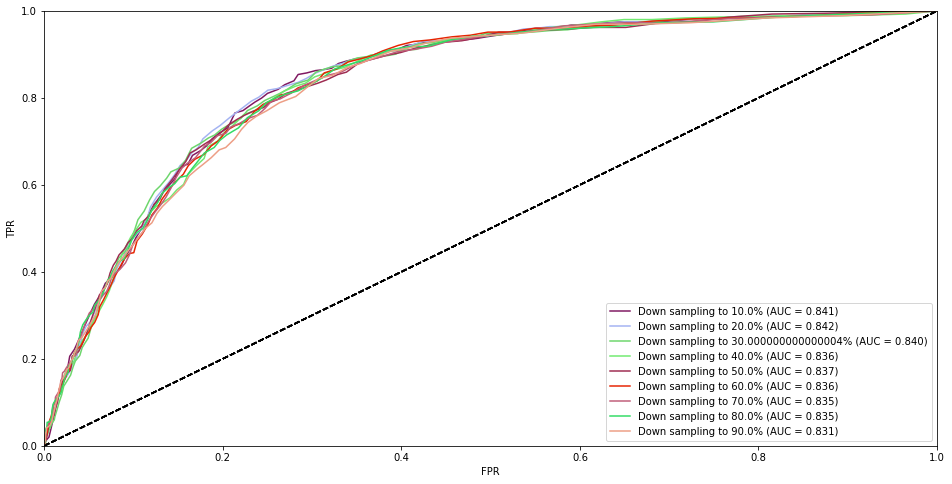

In [229]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12
fpr = {}
tpr = {}
plt.figure(figsize=(16,8))
for i in rf_clf_bin.keys():
    fpr[i], tpr[i], threshold = roc_curve(Y_test, y_proba_bin[i])
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    roc_auc = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color = c, label = 'Down sampling to {}%'.format(i*100)+' (AUC = %0.3f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc="lower right")
plt.show()

In [240]:
tab = dict(zip([0,1,2,3,4],[0,1,2,3,4]))
for i in rf_clf_bin.keys():
    #y_eval = np.vectorize(tab.get)(Y_test)
    #y_eval = y_eval.reshape(3564)
    #y_pred = np.vectorize(tab.get)(y_preds_bin[i])
    # Making the Confusion Matrix
    print(pd.DataFrame(confusion_matrix(Y_test, y_preds_bin[i], normalize = 'true'), columns = ['0', '1'], index = ['0','1']))

          0         1
0  0.705980  0.294020
1  0.142599  0.857401
          0         1
0  0.802990  0.197010
1  0.263538  0.736462
          0         1
0  0.841528  0.158472
1  0.342960  0.657040
          0         1
0  0.886379  0.113621
1  0.480144  0.519856
          0         1
0  0.896346  0.103654
1  0.505415  0.494585
          0         1
0  0.913621  0.086379
1  0.583032  0.416968
          0         1
0  0.920266  0.079734
1  0.602888  0.397112
          0         1
0  0.931561  0.068439
1  0.635379  0.364621
          0         1
0  0.938538  0.061462
1  0.667870  0.332130


In [260]:
train_data = target_df[target_df['YEAR']<=2016]
X_train = train_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
Y_train = train_data['Y_bin']

In [261]:
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test = test_data[['Y_bin']] 

In [262]:
rf_clf_bin_bal = RandomForestClassifier(n_estimators = 500, class_weight= 'balanced').fit(X_train, Y_train)

In [263]:
y_preds_bin_bal = rf_clf_bin_bal.predict(X_test)
y_proba_bin_bal = rf_clf_bin_bal.predict_proba(X_test)[:,1]

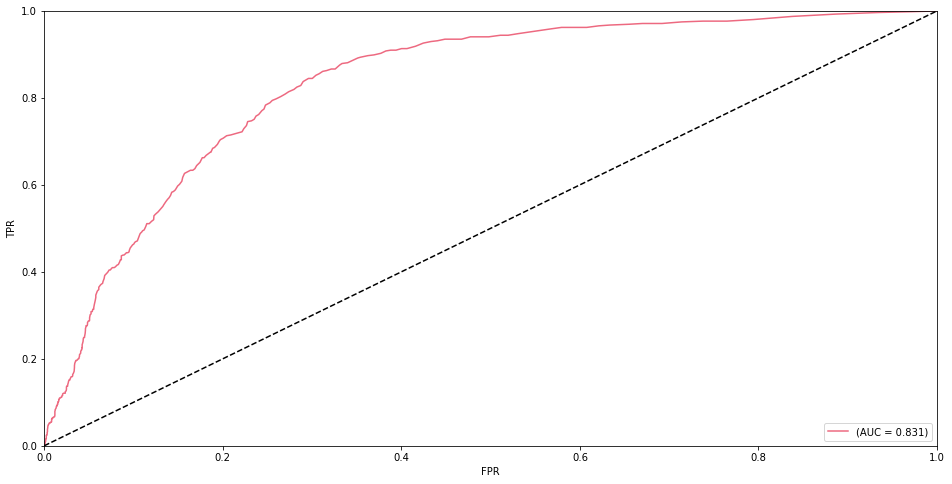

In [264]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12
plt.figure(figsize=(16,8))
fpr_bal, tpr_bal, threshold = roc_curve(Y_test, y_proba_bin_bal)
c = (np.random.rand(), np.random.rand(), np.random.rand())
roc_auc = auc(fpr[i], tpr[i])
plt.plot(fpr_bal, tpr_bal, color = c, label = '(AUC = %0.3f)' % roc_auc) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

In [266]:
print(pd.DataFrame(confusion_matrix(Y_test, y_preds_bin_bal, normalize = 'true', labels = [0,1]), \
                   columns = ['0', '1'], index = ['0','1']))

          0         1
0  0.973754  0.026246
1  0.861011  0.138989


In [270]:
feat_import = pd.DataFrame()
feat_import['col'] = X_train.columns
feat_import['feature_importance'] = rf_clf_bin_bal.feature_importances_
feat_import.sort_values(['feature_importance'], ascending = False)

,col,feature_importance
55,2 metre temperature hrs:18,0.058870
31,2 metre temperature hrs:0,0.047652
39,2 metre temperature hrs:6,0.036573
59,Total precipitation hrs:18,0.033618
51,Total precipitation hrs:12,0.032103
47,2 metre temperature hrs:12,0.028616
43,Total precipitation hrs:6,0.027294
35,Total precipitation hrs:0,0.026813
40,"Leaf area index, high vegetation hrs:6",0.026520
32,"Leaf area index, high vegetation hrs:0",0.026473


In [173]:
compare_df = Y_test.copy()
compare_df['Y_class_size_pred'] = y_preds_class_size
len(compare_df[(compare_df['Y_class_size_pred']==compare_df['Y_fire_class_size']) & (compare_df['Y_fire_class_size']>0)])

43

In [178]:
len(compare_df[(compare_df['Y_class_size_pred']>0) & (compare_df['Y_fire_class_size']==0)])/554

0.18050541516245489

In [182]:
rf_clf_bin = RandomForestClassifier().fit(X_train, Y_train)

<ipython-input-182-d718253a84e7>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf_bin = RandomForestClassifier().fit(X_train, Y_train)


In [183]:
y_preds_bin = rf_clf.predict(X_test)

In [187]:
y_bin_probs = rf_clf.predict_proba(X_test)[:,1]

In [186]:
tab = dict(zip([0,1,2,3,4],[0,1,2,3,4]))
y_eval = np.vectorize(tab.get)(Y_test)
y_eval = y_eval.reshape(3564)
y_pred = np.vectorize(tab.get)(y_preds_bin)
# Making the Confusion Matrix
print(pd.crosstab(y_eval, y_pred, rownames=['Actual Classes'], colnames=['Predicted Classes']))

Predicted Classes     0    1
Actual Classes              
0                  2837  173
1                   380  174


In [280]:
train_data = target_df[target_df['YEAR']<=2016]
train_samp = {}
X_train_samp = {}
Y_train_samp = {}
for i in np.arange(0.1, 1, 0.1):
    train_samp[i] = train_data[train_data['Y_bin']==1].append(train_data[train_data['Y_bin']==0].sample(frac=i))
    X_train_samp[i] = train_samp[i].drop('YEAR', axis = 1)
    print(len(X_train_samp[i][X_train_samp[i]['Y_bin']==0])/len(X_train_samp[i]))
    for y in Y_cols + non_mod_cols:
        try:
            X_train_samp[i].drop(y, inplace = True, axis =1)
        except:
            pass
    Y_train_samp[i] = train_samp[i][['Y_bin']]
    print(X_train_samp[i].shape)

0.4647978089254068
(6207, 60)
0.6345836541634584
(9091, 60)
0.7226118904475618
(11976, 60)
0.7764618800888231
(14861, 60)
0.8128028851572185
(17746, 60)
0.8389723703344644
(20630, 60)
0.8587284711886031
(23515, 60)
0.8741666666666666
(26400, 60)
0.8865592132222374
(29284, 60)


In [281]:
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test = test_data['Y_fire_area_prop']

In [282]:
rf_reg = {}
for i in X_train_samp.keys():
    print(i)
    rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])

0.1


<ipython-input-282-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.2


<ipython-input-282-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.30000000000000004


<ipython-input-282-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.4


<ipython-input-282-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.5


<ipython-input-282-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.6


<ipython-input-282-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.7000000000000001


<ipython-input-282-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.8


<ipython-input-282-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.9


<ipython-input-282-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


In [284]:
y_preds_reg = {}
y_proba_reg = {}
for i in rf_reg.keys():
    y_preds_reg[i] = rf_reg[i].predict(X_test)

R^2 value: -1044.9137891100695


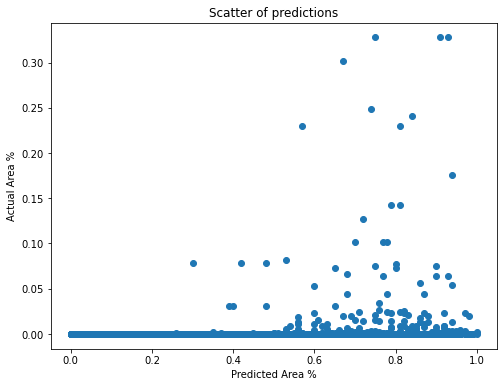

R^2 value: -801.4253123785016


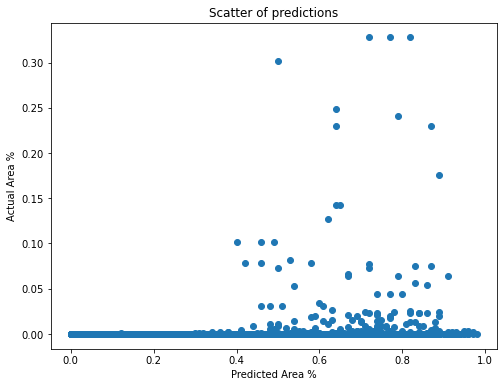

R^2 value: -654.1090227411124


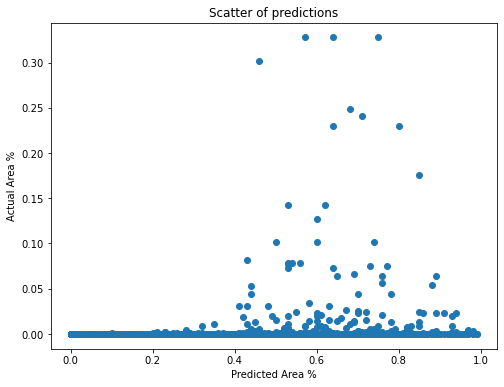

R^2 value: -561.4018727746352


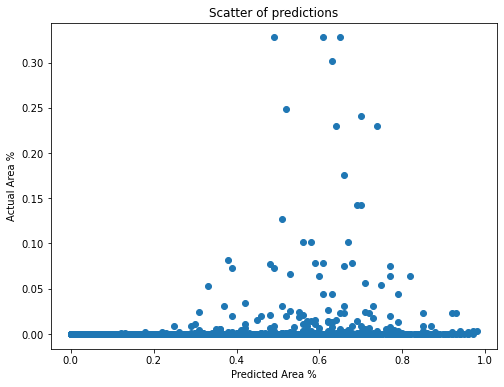

R^2 value: -509.84005450794757


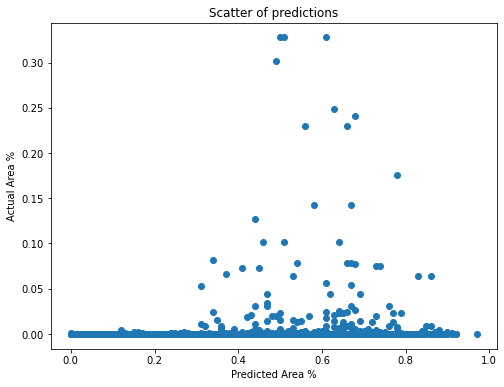

R^2 value: -457.3987032334606


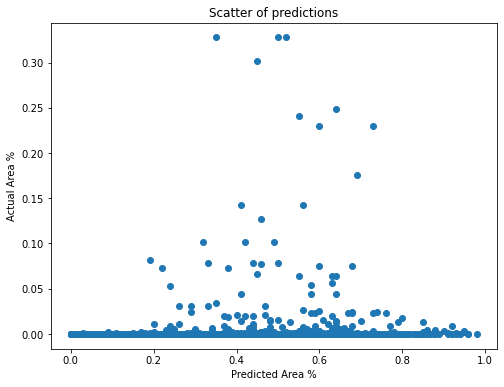

R^2 value: -422.84301659552773


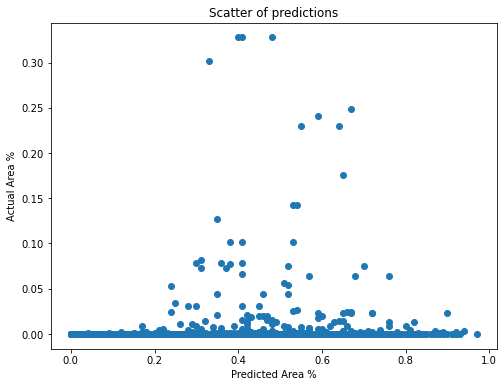

R^2 value: -381.9520636472714


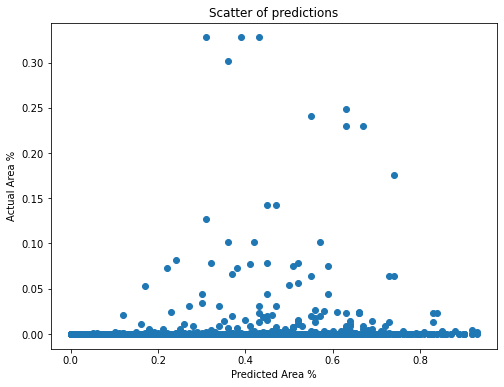

R^2 value: -368.8359047831417


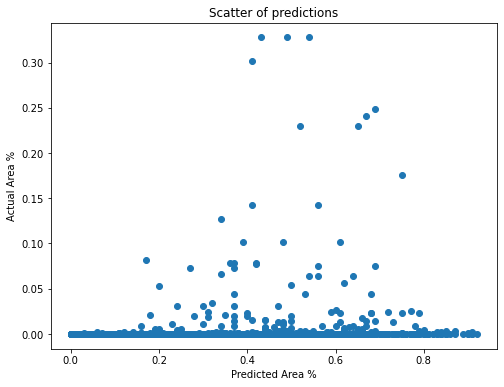

In [287]:
#plot predictions vs actuals
for i in X_train_samp.keys():
    plt.figure(figsize=(8,6))
    plt.scatter(y_preds_reg[i], Y_test)
    plt.title('Scatter of predictions')
    plt.xlabel('Predicted Area %')
    plt.ylabel('Actual Area %')
    #check R^2 value
    print("R^2 value:",rf_reg[i].score(X_test, Y_test))
    #print("MSE:",round(mean_squared_error(y_test_arr, preds_arrays),3))
    plt.show()

In [ ]:
corr = np.corrcoef(train_data[[i for i in train_data.columns if i not in non_mod_cols] + ['YEAR']])

In [292]:
[i for i in train_data.columns if i not in non_mod_cols] + ['YEAR']

['YEAR',
 'Y_bin',
 'Y_fire_class_size',
 'Y_fire_count',
 'Y_fire_area_prop',
 'elev_mean',
 'elev_std',
 'elev_media',
 'elev_max',
 'elev_min',
 'elev_range',
 'pl_count',
 'total_pl_length',
 'road_count',
 'total_road_length',
 'MEDIAN_AGE_TOT',
 'MEDIAN_AGE_MALE',
 'MEDIAN_AGE_FEM',
 'AGEUNDER13_TOT',
 'AGE1424_TOT',
 'AGE2544_TOT',
 'AGE4564_TOT',
 'AGE65PLUS_TOT',
 'POPDENSITY',
 'POPDENSITY_MALE',
 'POPDENSITY_FEM',
 'Structure Arsons',
 'Mobile Arsons',
 'Other Arsons',
 'Total Arsons',
 'Total Arsons Cleared',
 'Unemployment',
 'medianHHI2018',
 '10 metre U wind component hrs:0',
 '10 metre V wind component hrs:0',
 '2 metre dewpoint temperature hrs:0',
 '2 metre temperature hrs:0',
 'Leaf area index, high vegetation hrs:0',
 'Leaf area index, low vegetation hrs:0',
 'Surface pressure hrs:0',
 'Total precipitation hrs:0',
 '10 metre U wind component hrs:6',
 '10 metre V wind component hrs:6',
 '2 metre dewpoint temperature hrs:6',
 '2 metre temperature hrs:6',
 'Leaf area in